## 1. Import Libraries

Necessary libraries to execute the code

In [59]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import locale
locale.setlocale(locale.LC_ALL, '')
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import tensorflow as tf 
from flaml import AutoML
import shap 


C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data Import
The following code cell is used to download the dataset files from the Kaggle website. It only needs to be executed once.  
Additionally, you will need to generate a personal Kaggle API Token in your account settings and install kaggle (pip install kaggle). 
In my case, when generating the Token, it was not automatically saved locally, so I created the json file manually and saved it in the .Kaggle folder in users. It follows this structure: 
{
    "username": "your_username",
    "key": "copy the API TOKEN the first time is generated, or not visible anymore"
}

In [4]:
#def download_kaggle_dataset(dataset, path="data"):
     #if not os.path.exists(path):
         #os.makedirs(path)

     #api = KaggleApi()
     #api.authenticate()
     #api.dataset_download_files(dataset, path=path, unzip=True)
     #print("Dataset downloaded and extracted.")

#if __name__ == "__main__":
    #download_kaggle_dataset("barun2104/telecom-churn")

In [2]:
df=pd.read_csv('data/telecom_churn.csv')
print(df)
print("Dataset Columns: \n")
print(df.columns)

      Churn  AccountWeeks  ContractRenewal  ...  MonthlyCharge  OverageFee  RoamMins
0         0           128                1  ...           89.0        9.87      10.0
1         0           107                1  ...           82.0        9.78      13.7
2         0           137                1  ...           52.0        6.06      12.2
3         0            84                0  ...           57.0        3.10       6.6
4         0            75                0  ...           41.0        7.42      10.1
...     ...           ...              ...  ...            ...         ...       ...
3328      0           192                1  ...           71.7       10.78       9.9
3329      0            68                1  ...           56.4        7.67       9.6
3330      0            28                1  ...           56.0       14.44      14.1
3331      0           184                0  ...           50.0        7.98       5.0
3332      0            74                1  ...          100.0   

**ATTRIBUTES DESCRIPTION**
- Churn = The target variable indicating whether a customer canceled their service (1 = Yes, 0 = No)
- AccountWeeks = The number of weeks the customer has had an active account with the telecom provider
- ContractRenewal = A binary indicator of recent loyalty (1 if the customer recently renewed their contract, and 0 if they did not)
- DataPlan = Indicates if the customer has a data plan (1 = Yes, 0 = No)
- DataUsage = The amount of mobile data used by the customer, typically measured in gigabytes (GB) per month
- CustServCalls = The total number of calls made by the customer to customer service; high numbers often correlate with dissatisfaction
- DayMins = The average number of minutes the customer spends on calls during daytime hours each month
- DayCalls = The average number of distinct calls made by the customer during daytime hours
- MonthlyCharge = The average monthly bill amount charged to the customer
- OverageFee = The highest overage fee recorded for the customer in the last 12 months due to exceeding plan limits
- RoamMins = The average number of minutes spent on roaming (calls made outside the home network area) per month


## 3. Data Profiling
From this profiling we understand that we have 3332 rows of actual data (3333 considering the first row for attributes). We luckily don't have missing values nor duplicates. 

In [3]:
print("\nDataset Info: \n")
print(df.info())
print("\nMissing Values: \n")
print(df.isnull().sum()) 
print("\nDuplicate Values: \n")
print(df.duplicated().sum())
print("\nDescriptive Statistics:")
print(df.describe())


Dataset Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB
None

Missing Values: 

Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee   

Instead of just spotting the insights in the descriptive statistics manually, we can exploit some Python libraries useful for Exploratory Data Analysis (EDA) as a bridge between descriptive statistics and ML workflow, such as *seaborn* and *matplotlib*. 

**1. VISUALIZE CLASS IMBALANCE (CHURN RATE)**
It matters because if the churn group is too small, the ML model might struggle to learn their behavior. In this context, around 500 items is enough if careful when choosing the evaluation method.

Churn
0    85.508551
1    14.491449
Name: proportion, dtype: float64


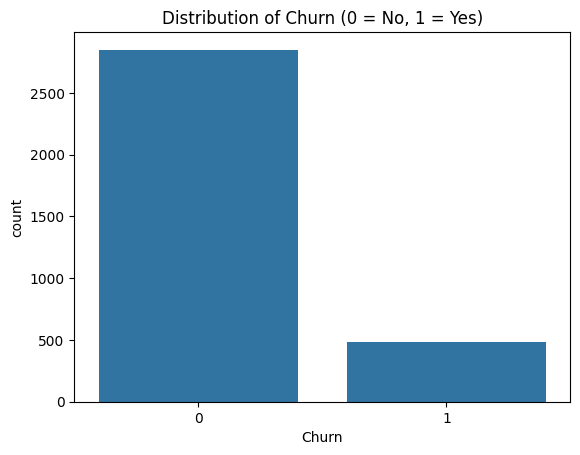

In [4]:
# Formula to see the exact counts and percentage
print(df['Churn'].value_counts(normalize=True) * 100)

sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn (0 = No, 1 = Yes)')
plt.show()

**2. IDENTIFY CORRELATIONS**
We can verify which attributes are most connected to the churn without checking each one manually with a heatmap.
Of course, we get some trivial insights, such as a positive and strong correlation between DataUsage and DataPlan or DataUsage and MonthlyCharge. 
With a combination of data filtering and correlation analysis, we can find some deeper insights to verify important correlations with the churn tendency (*see after the heatmap*)

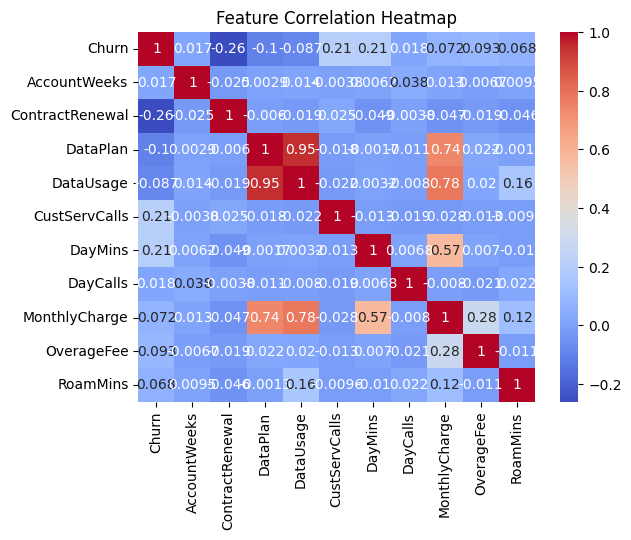

In [5]:
# Formula to see which features relate most to Churn
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [6]:
# Step 1: Filter the dataframe for only loyal customers (Churn == 0)
loyal_customers = df[df['Churn'] == 0]

# Step 2: Select the 'CustServCalls' column from that group and find the mean
avg_calls = loyal_customers['CustServCalls'].mean()

print("Average of Calls made by loyal customers (no churn): ", round(avg_calls,2))

Average of Calls made by loyal customers (no churn):  1.45


In [7]:
# Do the inverse for customers that quit
churned_customers = df[df['Churn'] == 1]
avg_calls = churned_customers['CustServCalls'].mean()
print ("Average of Calls made by churned customers (no churn): ", round(avg_calls,2))

Average of Calls made by churned customers (no churn):  2.23


If CustServCalls has a correlation of 0.21 with Churn, it means as calls increase, the likelihood of churn also increases. It might seem a small number in absolute terms, but it is an interesting finding for this type of data, also because it is the highest we can find in relation to churn in the matrix. The value 1.45 is the mean of the CustServCalls column, but only for the rows where the customer did not churn. Correlation measures the linear strength of the relationship across the entire dataset, but the averages tell the story of the groups, because the 2.23 instead underlines a 54% increase in the in call volume for the churn group, so the correlation is numerically low but the physical reality is still impactiful. 

**The Heavy Users Paradox**
In many industries, you might expect unhappy customers to be those who don't use the service much, but this dataset shows the opposite. By looking at the Avg DayMins, there is a clear difference between loyal and churned clients. Churners talk about 18% more during the day than loyal customers, so they are also being billed more. 

In [8]:
loyal_customers = df[df['Churn'] == 0]
avg_mins = loyal_customers['DayMins'].mean()
print ("Average Minutes per Day of service usage for loyal customers: ", int(avg_mins))

Average Minutes per Day of service usage for loyal customers:  175


In [9]:
churned_customers = df[df['Churn'] == 1]
avg_mins = churned_customers['DayMins'].mean()
print ("Average Minutes per Day of service usage for churned customers: ", int(avg_mins))

Average Minutes per Day of service usage for churned customers:  206


In [10]:
loyal_customers = df[df['Churn'] == 0]
avg_monchar = loyal_customers['MonthlyCharge'].mean()
print ("Average Monthly Charge for loyal customers: ", locale.currency(round(avg_monchar,2), grouping=True))

Average Monthly Charge for loyal customers:  55,82 €


In [11]:
churned_customers = df[df['Churn'] == 1]
avg_monchar = churned_customers['MonthlyCharge'].mean()
print ("Average Monthly Charge for churned customers: ", locale.currency(round(avg_monchar,2), grouping=True))

Average Monthly Charge for churned customers:  59,19 €


In [12]:
loyal_customers = df[df['Churn'] == 0]
avg_overfee = loyal_customers['OverageFee'].mean()
print ("Average Overage Fee for loyal customers: ", locale.currency(round(avg_overfee,2), grouping=True))

Average Overage Fee for loyal customers:  9,95 €


In [13]:
churned_customers = df[df['Churn'] == 1]
avg_overfee = churned_customers['OverageFee'].mean()
print ("Average Overage Fee for churned customers: ", locale.currency(round(avg_overfee,2), grouping=True))

Average Overage Fee for churned customers:  10,62 €


The Usage Intensity insight reveals a specific business problem: the most active users that therefore generate the most revenue are the ones leaving. If someone uses a lot of minutes and sees high monthly charges plus overage fees, is more prone to look for better alternatives by competitors. Usually, high usage is seen as engagement, but in this dataset high usage is actually a warning sign that the customer might find a better deal elsewhere.

## 4. DATA PREPROCESSING
### DATA CLEANING
We don't deal with missing or duplicate values. Anyways, we can apply dimensionality reduction and feature engineering to exploit high correlation that does not reach a threshold such that we can directly drop one.  

In [14]:
# Feature Engineering: Merging Redundant Attributes
# Creating 'PricePerMinute' merges the financial impact of 'MonthlyCharge' with the usage in 'DayMins'
# use np.where fix for PricePerMinute to remove the "billion-dollar" artifacts.
df['PricePerMinute'] = np.where(
    df['DayMins'] > 0, 
    df['MonthlyCharge'] / df['DayMins'], 
    0  # Set to 0 if they didn't talk, instead of a 'billion dollar' artifact
)
# Dimensionality Reduction
# Dropping 'MonthlyCharge' because now we have 'PricePerMinute' 
# and drop 'DataPlan' because 'DataUsage' provides the same info but with higher granularity
df = df.drop(columns=['DataPlan', 'MonthlyCharge'])

# Verify the changes
print(f"New column count: {len(df.columns)}")
print(df[['DayMins', 'PricePerMinute']].head())



New column count: 10
   DayMins  PricePerMinute
0    265.1        0.335722
1    161.6        0.507426
2    243.4        0.213640
3    299.4        0.190381
4    166.7        0.245951


During preprocessing, we can run a quick RandomForest just to see the Feature Importance chart to guide attribute seleciton. To make it effective, we set some parameters first, like *class_weight='balance'* because we only have 14.5% of the customers churned, and this tells the mforest to pay more attention to those individuals so their behavior isn't ignored; the *n_estimators=100* as standard tradeoff between stable importance score and time spent; the *random_state=42* to ensure that every time we run the code we get the same importance score not to randomly change conclusions. 
In machine learning, a common rule of thumb for feature selection is to keep attributes that contribute at least 5% (0.05) to the model's decision-making. 

In [15]:
# 1. Prepare Features (X) and Target (y)
# We drop Churn (target) and the redundant columns we identified earlier
X = df.drop(columns=['Churn'])
y = df['Churn']

# 2. Split the data
# Even for importance, splitting ensures the model doesn't just "memorize" the whole set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Set up and Train the Random Forest
# Note the 'class_weight' parameter to handle the 14.5% churn imbalance
rf_selector = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_selector.fit(X_train, y_train)

# 4. Extract and visualize the results
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances)

           Feature  Importance
4          DayMins    0.246203
3    CustServCalls    0.173283
6       OverageFee    0.118701
8   PricePerMinute    0.113448
1  ContractRenewal    0.103317
7         RoamMins    0.068765
0     AccountWeeks    0.063022
5         DayCalls    0.060942
2        DataUsage    0.052319


In [16]:
# Filter the dataframe for users with zero DayMins
zero_daymins_users = df[df['DayMins'] == 0]

# Display the count and the specific rows
print(f"Number of users with 0 DayMins: {len(zero_daymins_users)}")
print(zero_daymins_users[['DayMins', 'DataUsage', 'Churn']])

Number of users with 0 DayMins: 2
      DayMins  DataUsage  Churn
1345      0.0        0.0      1
1397      0.0        0.3      0


In [17]:
# Filter for zero data usage
zero_data_users = df[df['DataUsage'] == 0]

print(f"Number of users with 0 DataUsage: {len(zero_data_users)}")

Number of users with 0 DataUsage: 1813


### Statistics for DataUsage
calculate the churn rate for people who use zero data versus those who do.

In [18]:
# Create a group for zero vs non-zero usage
zero_data_stats = df.groupby(df['DataUsage'] == 0)['Churn'].mean() * 100

print("Churn Rate based on Data Usage:")
print(f"- Users with 0 Data Usage: {zero_data_stats[True]:.2f}%")
print(f"- Users with >0 Data Usage: {zero_data_stats[False]:.2f}%")

Churn Rate based on Data Usage:
- Users with 0 Data Usage: 17.76%
- Users with >0 Data Usage: 10.59%


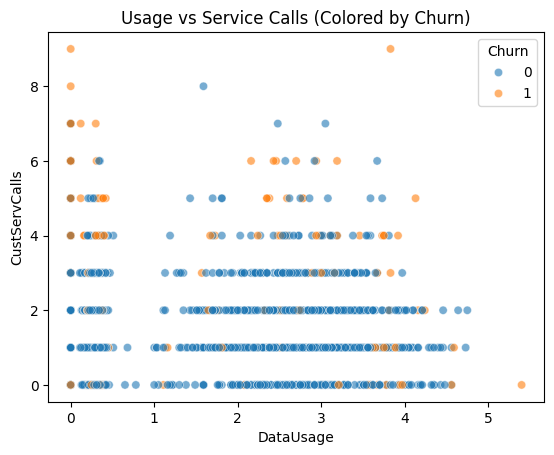

In [19]:
sns.scatterplot(data=df, x='DataUsage', y='CustServCalls', hue='Churn', alpha=0.6)
plt.title('Usage vs Service Calls (Colored by Churn)')
plt.show()

This shows if churners gather in specific "zones". Data usage is less impacting. The real discriminating factor in this comparison is still the calls to the customer service.

### Statistics for DayMins
Since there are only 2 users with exactly zero minutes, a "percentage" can be misleading (50%), so it's better to show the raw data for them to prove the point.

In [20]:
# Check the specific users with 0 DayMins
zero_mins_users = df[df['DayMins'] == 0]

print(f"\nAnalysis of the {len(zero_mins_users)} users with 0 DayMins:")
print(zero_mins_users[['DayMins', 'Churn']])

# Compare to the rest of the population
average_churn = df[df['DayMins'] > 0]['Churn'].mean() * 100
print(f"\nChurn rate for all other users: {average_churn:.2f}%")


Analysis of the 2 users with 0 DayMins:
      DayMins  Churn
1345      0.0      1
1397      0.0      0

Churn rate for all other users: 14.47%


Out of the 2 users who had 0 minutes, one churned (50% churn rate). While the sample size is tiny, it's still significantly higher than the average population churn rate of 14.47%. 

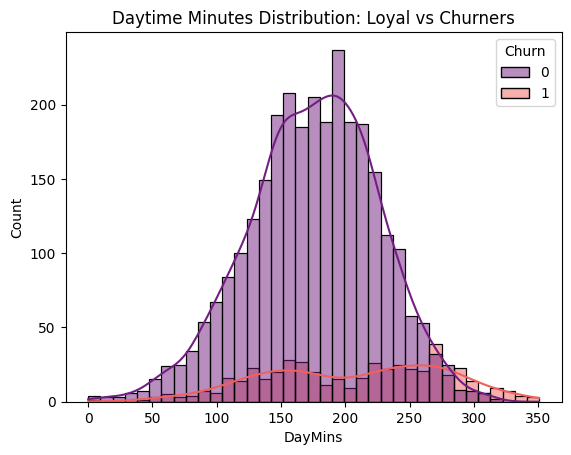

In [21]:
sns.histplot(data=df, x='DayMins', hue='Churn', kde=True, palette='magma')
plt.title('Daytime Minutes Distribution: Loyal vs Churners')
plt.show()

This shows two overlapping distributions, one for those who stayed and one for those who left. Colors represent loyalty (y/n). This proves that churners generally talk more than loyals. 

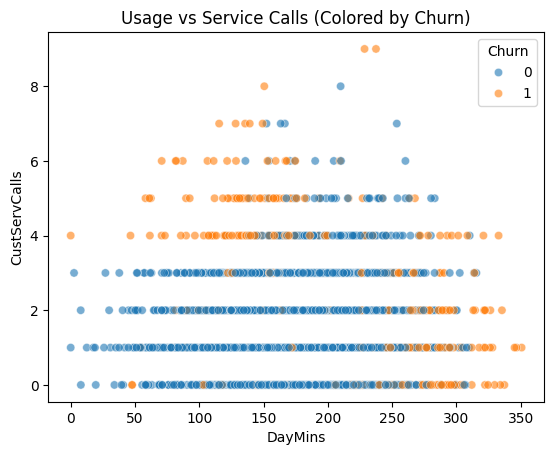

In [22]:
sns.scatterplot(data=df, x='DayMins', y='CustServCalls', hue='Churn', alpha=0.6)
plt.title('Usage vs Service Calls (Colored by Churn)')
plt.show()

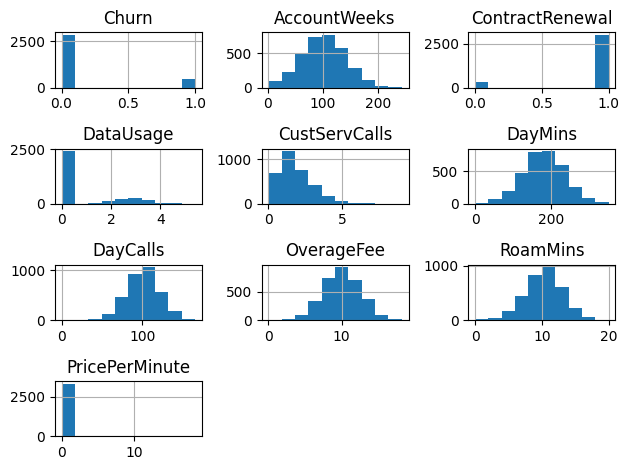

In [23]:
#histogram to show density and distribution
df.hist()
plt.tight_layout()

Text(0.5, 1.0, 'Detailed PricePerMinute Distribution')

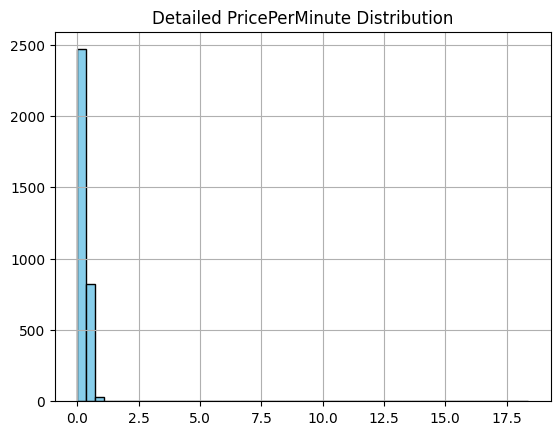

In [24]:
# Increase the number of 'bins' (buckets) to 50 to better visualize the distribution 
df['PricePerMinute'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Detailed PricePerMinute Distribution')

(0.0, 1.0)

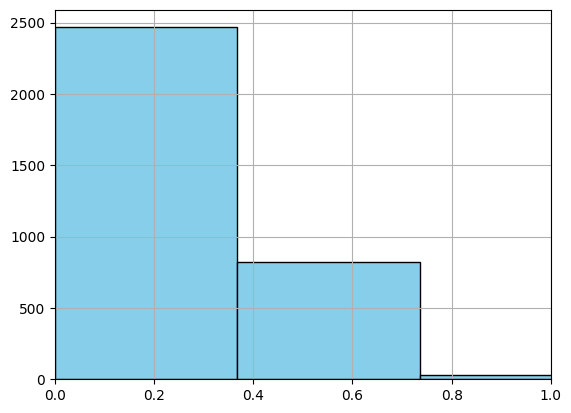

In [25]:
# OR: Force the view to only show 0 to $1
df['PricePerMinute'].hist(bins=50, color='skyblue', edgecolor='black')
plt.xlim(0, 1)

### Outlier Detection

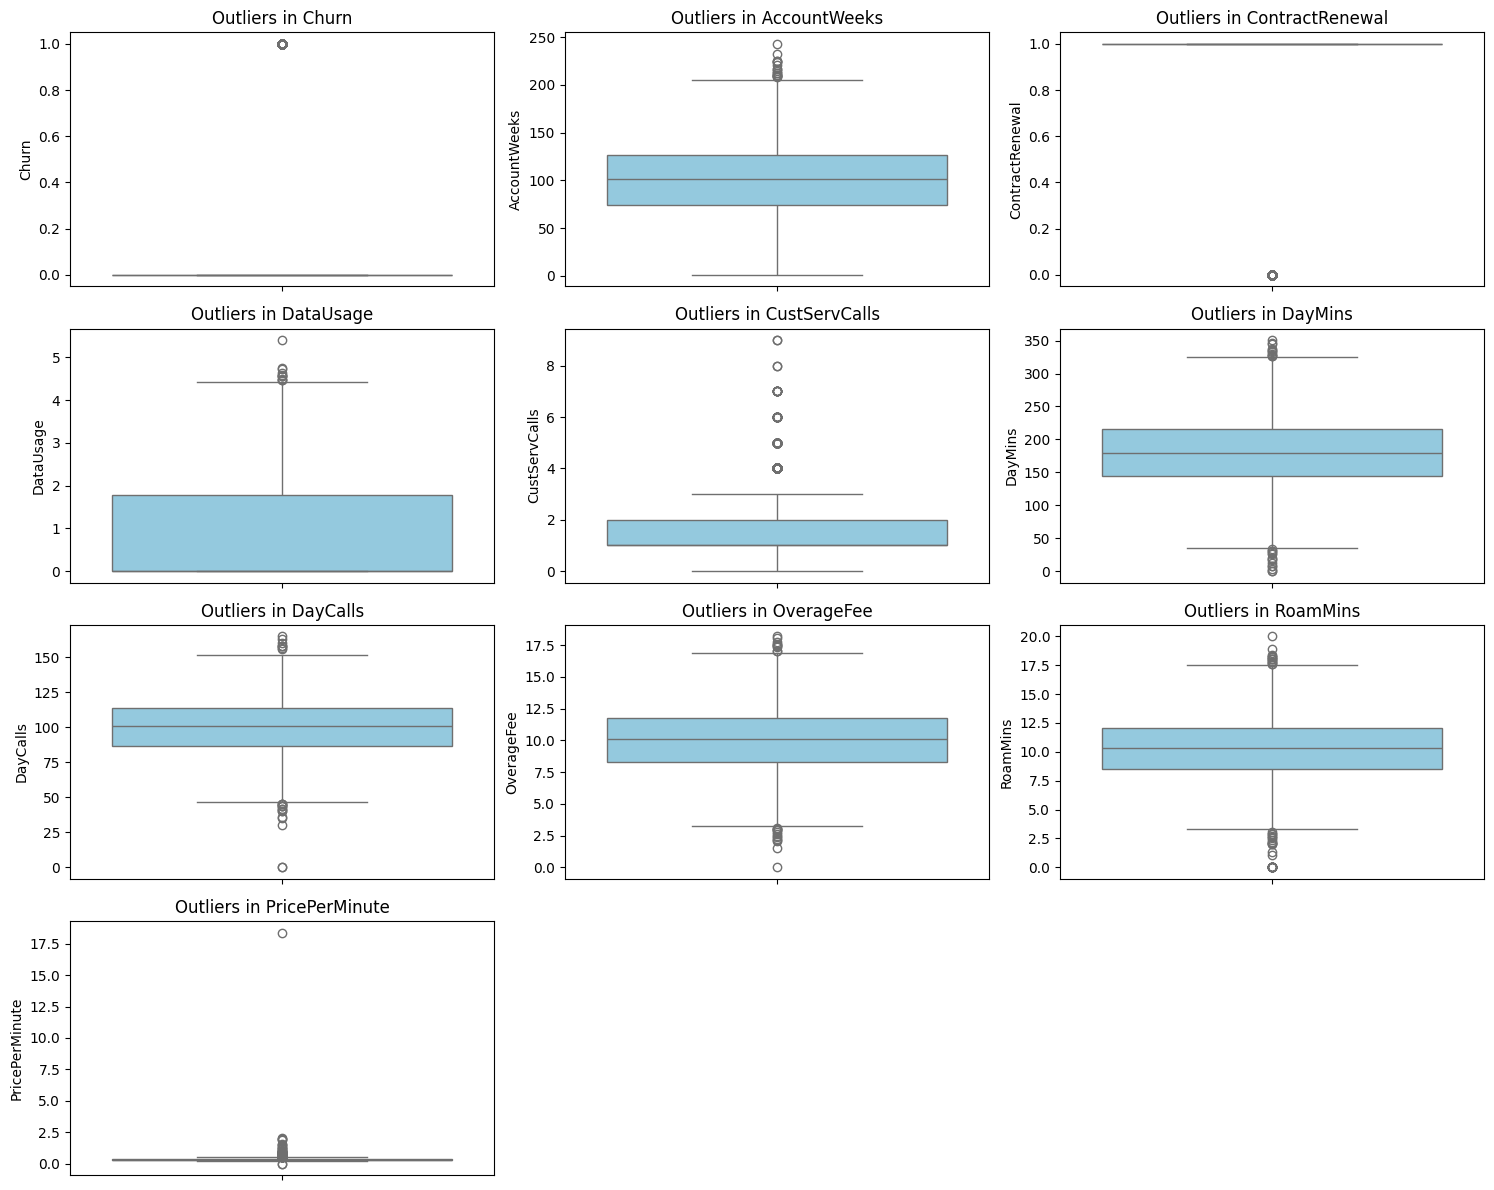

In [26]:
# Select only numeric columns for analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

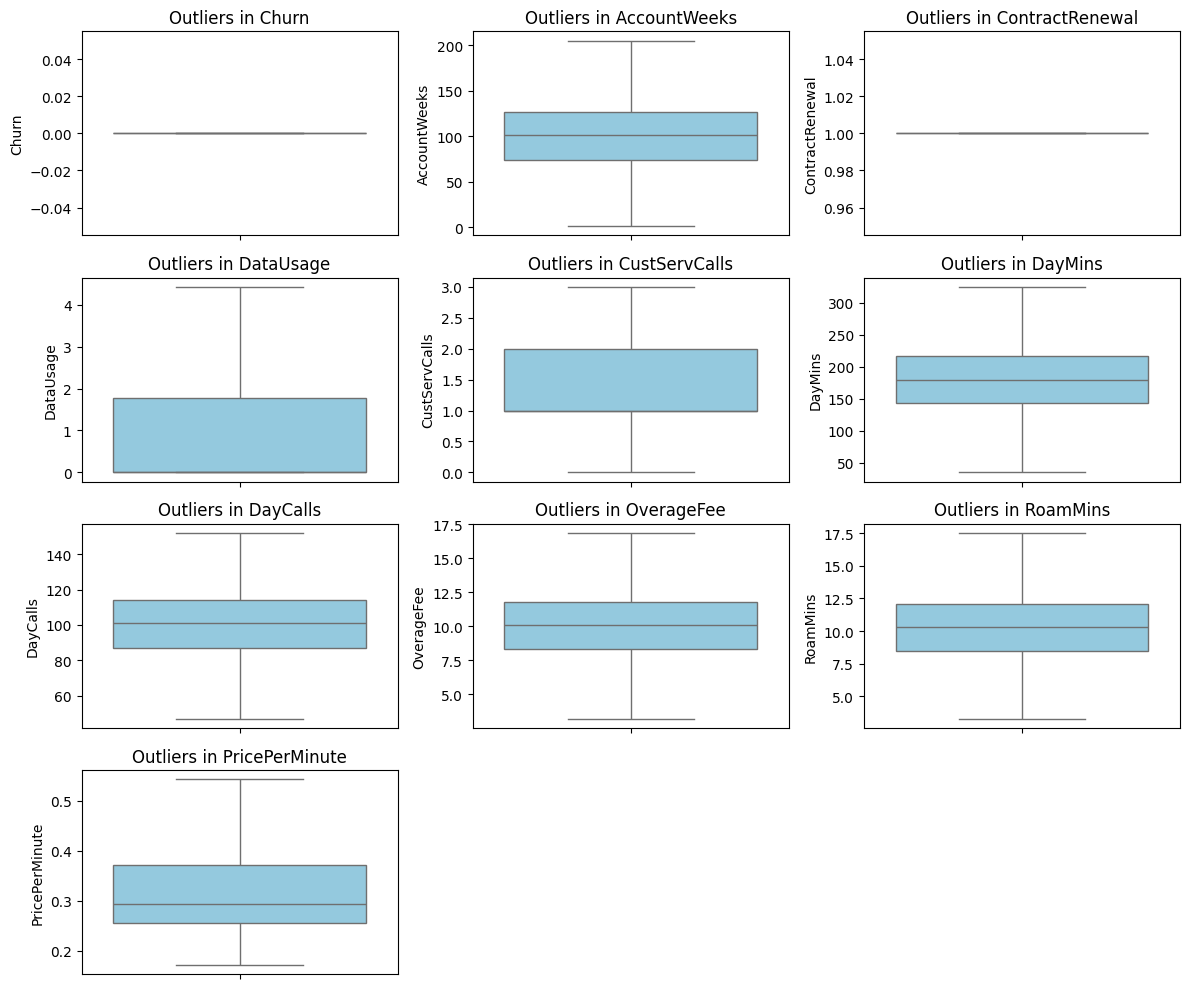

In [27]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i+1)
    sns.boxplot(y=df[col], showfliers=False, color='skyblue')
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

In [28]:
def outlier_report(data):
    report = []
    for col in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        count = ((data[col] < lower) | (data[col] > upper)).sum()
        report.append({
            'Feature': col,
            'Outliers': count,
            'Lower Bound': round(lower, 2),
            'Upper Bound': round(upper, 2)
        })
    return pd.DataFrame(report).sort_values(by='Outliers', ascending=False)

print(outlier_report(df))

           Feature  Outliers  Lower Bound  Upper Bound
0            Churn       483         0.00         0.00
2  ContractRenewal       323         1.00         1.00
4    CustServCalls       267        -0.50         3.50
9   PricePerMinute       175         0.08         0.54
8         RoamMins        46         3.10        17.50
5          DayMins        25        34.65       325.45
7       OverageFee        24         3.17        16.93
6         DayCalls        23        46.50       154.50
1     AccountWeeks        18        -5.50       206.50
3        DataUsage        11        -2.67         4.45


PricePerMinute (Upper Bound: 0.54): Customers paying over 54 cents per minute are outliers. We should check if these are real (heavy roaming users) or if they represent data errors.

DayMins (Lower Bound: 34.6): Customers who talk less than 34 minutes a month are outliers. If their MonthlyCharge is still high, they are at very high risk of leaving because they aren't getting value.

In [29]:
# Reload original dataset to see the full context
df_orig = pd.read_csv('data/telecom_churn.csv')

# Check the "Expensive" outliers
ppm_threshold = 0.54
expensive_customers = df_orig[df_orig['MonthlyCharge'] / (df_orig['DayMins'] + 1e-9) > ppm_threshold]

print("Expensive outliers who are actually Data Users:")
print(expensive_customers[expensive_customers['DataUsage'] > 1.0].head())

# High Minute Users vs churn
print("\nHigh Minute Users and their Churn status:")
print(df_orig[df_orig['DayMins'] > 325][['DayMins', 'CustServCalls', 'Churn']])

Expensive outliers who are actually Data Users:
     Churn  AccountWeeks  ContractRenewal  ...  MonthlyCharge  OverageFee  RoamMins
115      1            36                0  ...          110.0       12.75      20.0
182      0            67                1  ...           66.7       11.89       9.9
200      0            53                1  ...           79.4       11.03      13.1
205      0            66                1  ...           68.7       10.49      12.1
246      0           107                1  ...           49.0        5.11      11.1

[5 rows x 11 columns]

High Minute Users and their Churn status:
      DayMins  CustServCalls  Churn
15      332.9              4      1
156     337.4              0      1
197     326.5              2      1
365     350.8              1      1
605     335.5              2      1
975     334.3              0      1
985     346.8              1      1
1679    329.8              0      1
2028    328.1              1      1
2412    326.3         

ContractRenewal
1    3010
0     323
Name: count, dtype: int64


Text(0.5, 1.0, 'Frequency of Contract Renewals')

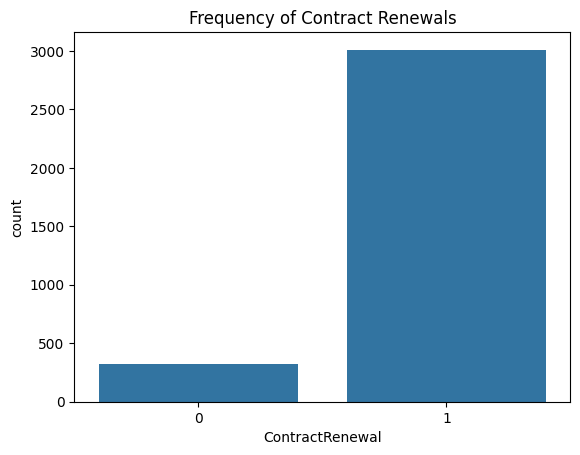

In [30]:
# The correct way to look at ContractRenewal
print(df['ContractRenewal'].value_counts())

# Or visually:
sns.countplot(x='ContractRenewal', data=df)
plt.title('Frequency of Contract Renewals')

### Isolation Forest for Outlier Detection
Effective because it does not assume a normal distribution. The strength of Isolation Forest is that it finds combinations of features that are rare, even if individual values aren't extreme.

In [31]:
# contamination=0.05 assumes roughly 5% of data is outliers
iso = IsolationForest(contamination=0.05, random_state=42)
outliers = iso.fit_predict(df.drop('Churn', axis=1))
df['is_outlier'] = outliers # 1 for normal, -1 for outlier

# Print the count of detected outliers
print(f"Outlier Count: {len(df[df['is_outlier'] == -1])}")
print(f"Normal Count: {len(df[df['is_outlier'] == 1])}")

# Show the first 5 outliers detected
print("\nSample of detected outliers:")
display(df[df['is_outlier'] == -1].head())

# Clean the dataframe for the final model
df_cleaned = df[df['is_outlier'] == 1].drop(columns=['is_outlier'])
display(df_cleaned)

Outlier Count: 167
Normal Count: 3166

Sample of detected outliers:


,Churn,AccountWeeks,ContractRenewal,DataUsage,CustServCalls,DayMins,DayCalls,OverageFee,RoamMins,PricePerMinute,is_outlier
3,0,84,0,0.00,2,299.4,71,3.10,6.6,0.190381,-1
9,0,141,0,3.02,0,258.6,84,11.10,11.2,0.360402,-1
15,1,161,1,0.00,4,332.9,67,15.89,5.4,0.252328,-1
36,0,36,1,3.92,0,146.3,128,8.13,14.5,0.534518,-1
41,1,135,0,3.94,0,173.1,85,10.20,14.6,0.499133,-1


,Churn,AccountWeeks,ContractRenewal,DataUsage,CustServCalls,DayMins,DayCalls,OverageFee,RoamMins,PricePerMinute
0,0,128,1,2.70,1,265.1,110,9.87,10.0,0.335722
1,0,107,1,3.70,1,161.6,123,9.78,13.7,0.507426
2,0,137,1,0.00,0,243.4,114,6.06,12.2,0.213640
4,0,75,0,0.00,3,166.7,113,7.42,10.1,0.245951
5,0,118,0,0.00,0,223.4,98,11.03,6.3,0.255148
...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,2.67,2,156.2,77,10.78,9.9,0.459027
3329,0,68,1,0.34,3,231.1,57,7.67,9.6,0.244050
3330,0,28,1,0.00,2,180.8,109,14.44,14.1,0.309735
3331,0,184,0,0.00,2,213.8,105,7.98,5.0,0.233863


In [32]:
# Compare means of Outliers vs Normal customers
comparison = df.groupby('is_outlier').mean()
print(comparison)

               Churn  AccountWeeks  ...   RoamMins  PricePerMinute
is_outlier                          ...                           
-1          0.341317    111.922156  ...  11.489820        0.673303
 1          0.134555    100.492104  ...  10.171226        0.320785

[2 rows x 10 columns]


### Logarithmic Transformation
Applied on DataUsage and CustServCalls since they are highly skewed and a Gaussian-like distribution can work better with some types of algorithms in the modeling phase. It can be useful to compare algos on raw data vs log data. 

Skewness before log (DataUsage): 1.2720573148196221
Skewness after log (DataUsage): 1.0271807545548228
Skewness before log (CustServCalls): 1.0913594824728512
Skewness before log (CustServCalls): -0.13856793975410003


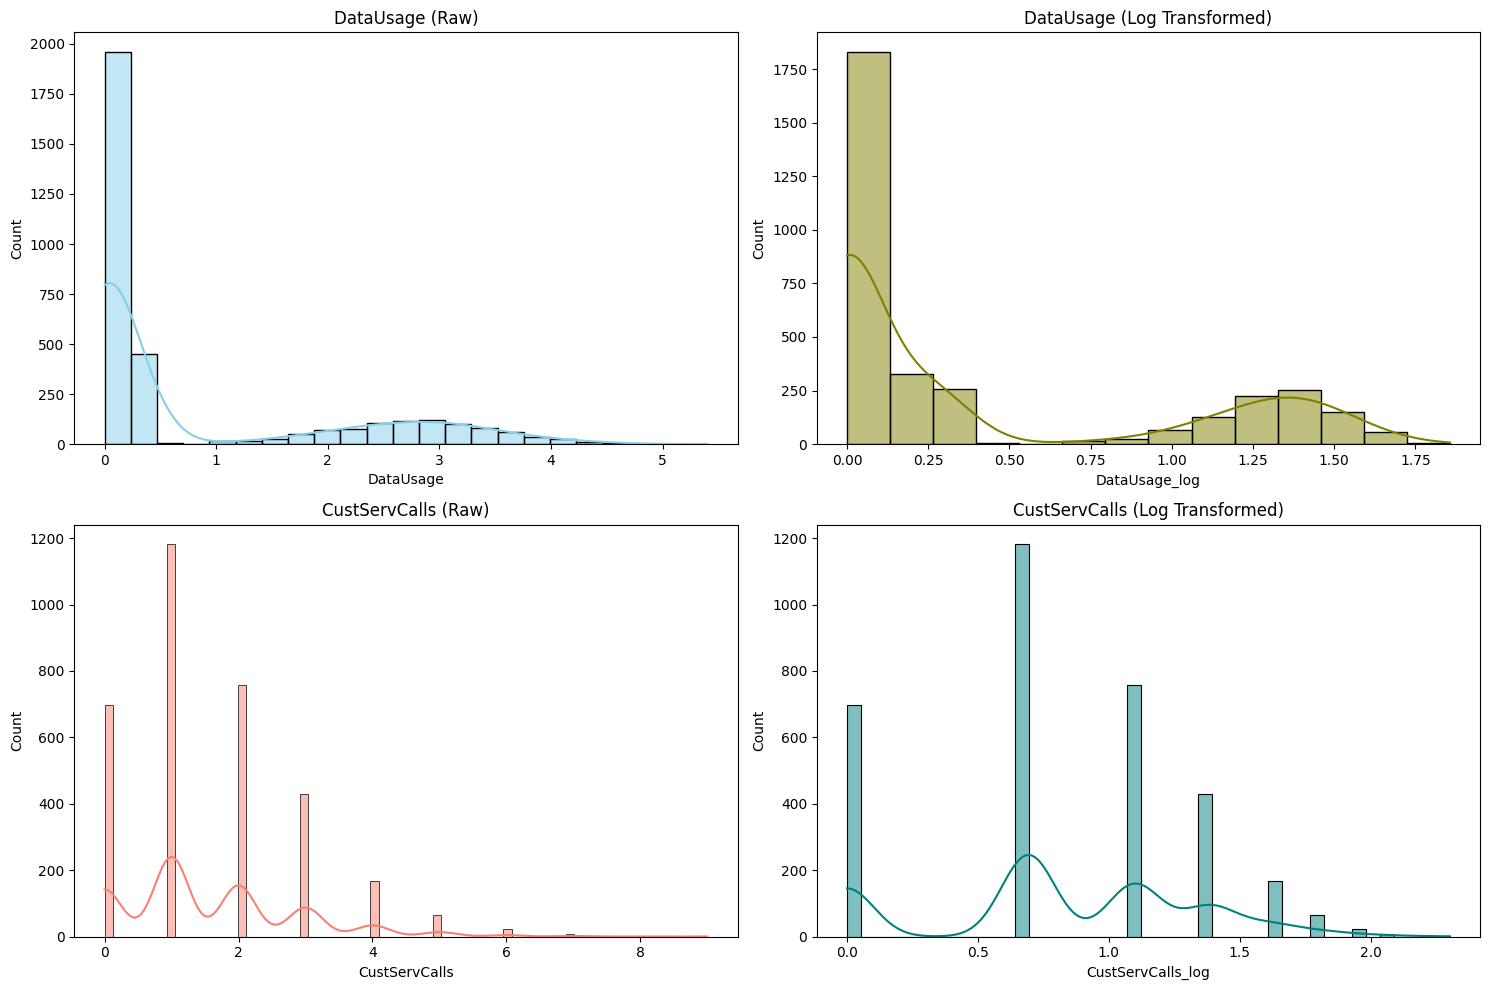

Skewness improvement for DataUsage: 1.27 -> 1.03
Skewness improvement for CustServCalls: 1.09 -> -0.14


In [33]:
# Apply transformation to create new Gaussian-like features
df['DataUsage_log'] = np.log1p(df['DataUsage'])
df['CustServCalls_log'] = np.log1p(df['CustServCalls'])

# Check the new distribution
print("Skewness before log (DataUsage):", df['DataUsage'].skew())
print("Skewness after log (DataUsage):", df['DataUsage_log'].skew())
print("Skewness before log (CustServCalls):", df['CustServCalls'].skew())
print("Skewness before log (CustServCalls):", df['CustServCalls_log'].skew())

# Set up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# DataUsage Comparison
sns.histplot(df['DataUsage'], kde=True, ax=axes[0, 0], color='skyblue').set_title('DataUsage (Raw)')
sns.histplot(df['DataUsage_log'], kde=True, ax=axes[0, 1], color='olive').set_title('DataUsage (Log Transformed)')

# CustServCalls Comparison
sns.histplot(df['CustServCalls'], kde=True, ax=axes[1, 0], color='salmon').set_title('CustServCalls (Raw)')
sns.histplot(df['CustServCalls_log'], kde=True, ax=axes[1, 1], color='teal').set_title('CustServCalls (Log Transformed)')

plt.tight_layout()
plt.show()

# Print mathematical proof of improvement (Skewness closer to 0 is better)
print(f"Skewness improvement for DataUsage: {df['DataUsage'].skew():.2f} -> {df['DataUsage_log'].skew():.2f}")
print(f"Skewness improvement for CustServCalls: {df['CustServCalls'].skew():.2f} -> {df['CustServCalls_log'].skew():.2f}")

In [34]:
# Create a binary feature: 1 if user used data, 0 otherwise
df['HasDataUsage'] = (df['DataUsage'] > 0).astype(int)

# Verify the transformation
print(df[['DataUsage', 'HasDataUsage']].head(10))
print("\nValue Counts for the new binary feature:")
print(df['HasDataUsage'].value_counts())

   DataUsage  HasDataUsage
0       2.70             1
1       3.70             1
2       0.00             0
3       0.00             0
4       0.00             0
5       0.00             0
6       2.03             1
7       0.00             0
8       0.19             1
9       3.02             1

Value Counts for the new binary feature:
HasDataUsage
0    1813
1    1520
Name: count, dtype: int64


## 5. Modeling 
In this part, we run the algorithms that can suit our case and we compare the alternatives with quantitative metrics. 

### Standardization
With StandardScaler we scale our features (except for churn) to have a mean of 0 and standard deviation of 1. We need it because ANN and PCA are highly sensitive to ranges. 

In [35]:
# 1. Define the features to scale
X = df_cleaned.drop(columns=['Churn'])
y = df_cleaned['Churn']

# 2. Split the data first (to avoid data leakage during scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initialize and apply the scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Check prediction complexity
PCA and t-SNE are sequentially a linear and non-linear methods to understand how difficult it is to correctly separate items into groups in our dataset. The more datapoints overlap, the harder it is, meaning that instances have lots of features in common that make them look similar. 

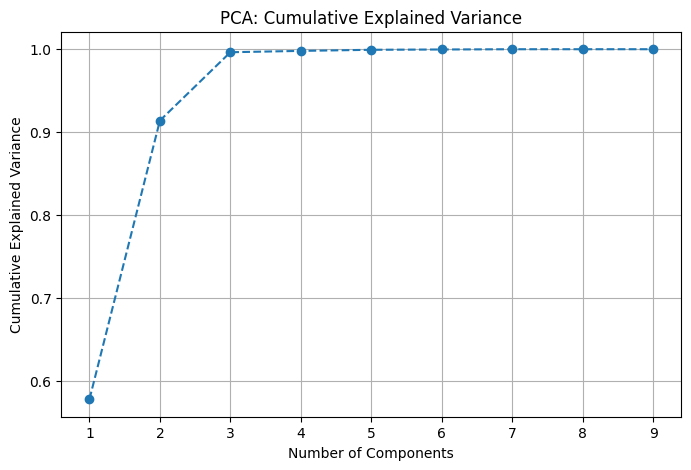

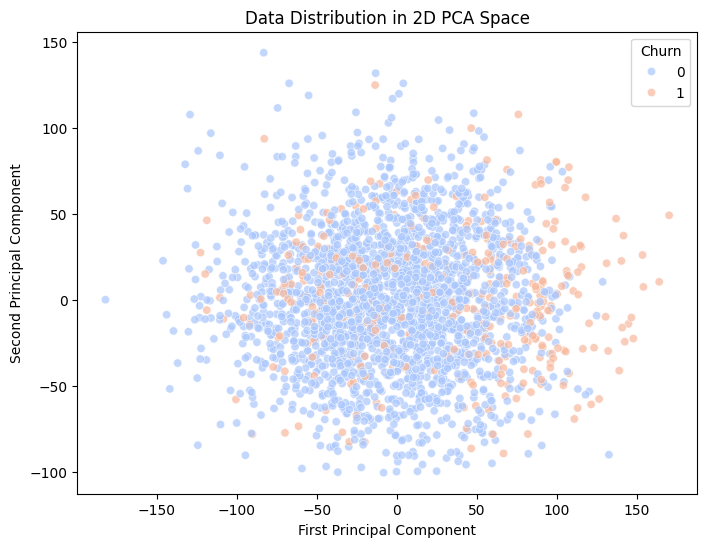

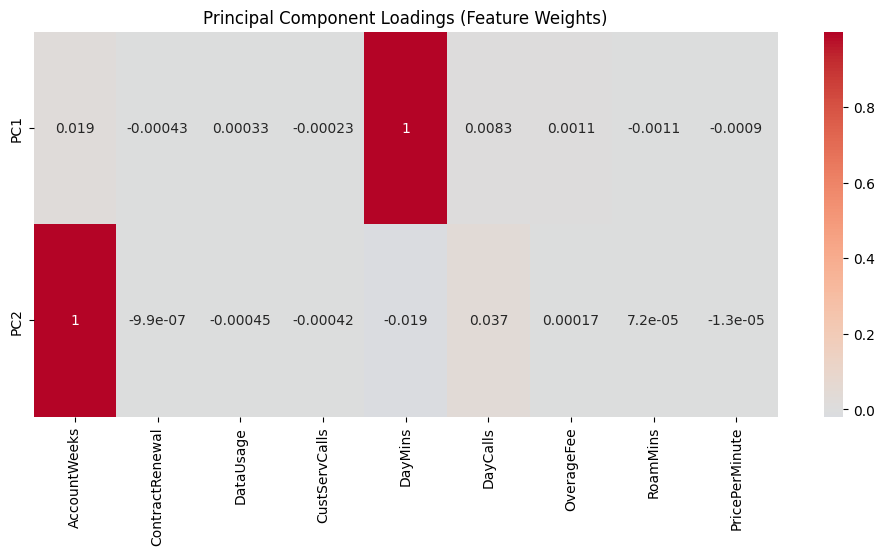

In [36]:
# PCA
# Using the scaled training data
pca = PCA(n_components=None) # Start by looking at all components
pca.fit(X_train)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting the Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('PCA: Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Visualize the first two components
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_train)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='coolwarm', alpha=0.7)
plt.title('Data Distribution in 2D PCA Space')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

loadings = pd.DataFrame(
    pca.components_[:2],  # We take the first two components
    columns=X.columns,
    index=['PC1', 'PC2']
)

plt.figure(figsize=(12, 5))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Principal Component Loadings (Feature Weights)')
plt.show()

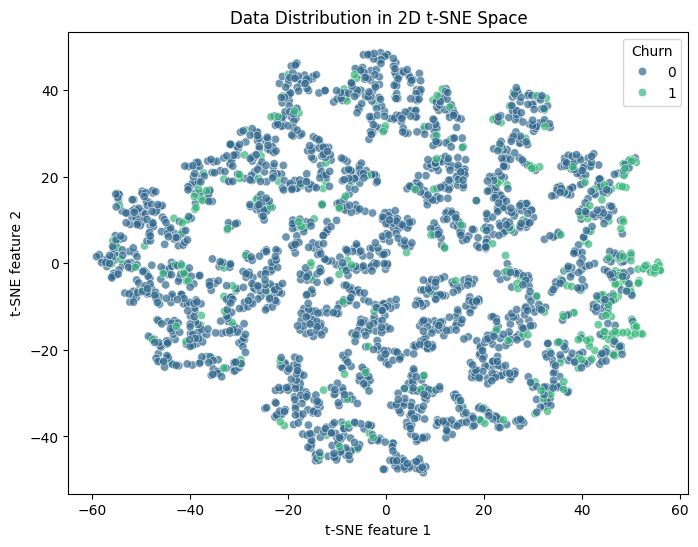

t-SNE Silhouette Score: 0.071


In [37]:
# t-SNE can be computationally expensive, so we use a subset if needed or just the training set
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train, palette='viridis', alpha=0.7)
plt.title('Data Distribution in 2D t-SNE Space')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

# Higher score = easier prediction task
score = silhouette_score(X_tsne, y_train)
print(f"t-SNE Silhouette Score: {score:.3f}")

In [38]:
# Prepare Data for Models (from cleaned dataset)
X = df_cleaned.drop(columns=['Churn'])
y = df_cleaned['Churn']

#Prepare Data for Models (from complete df with outliers)
Z = df.drop(columns=['Churn'])
k = df['Churn']

# Stratified split to maintain the 14.5% churn ratio in both sets (cleaned)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Stratified split to maintain the 14.5% churn ratio in both sets (original)
Z_train, Z_test, k_train, k_test = train_test_split(
    Z, k, test_size=0.2, random_state=42, stratify=k
)

# HELPER FUNCTION FOR EVALUATION
def evaluate_model(model, X_test, y_test, name):
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Stayed', 'Churned'], 
                yticklabels=['Stayed', 'Churned'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()
    acc = accuracy_score(y_test, preds)
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.2f}")
    print(classification_report(y_test, preds))
    return acc

# ROC AUC AND ROC CURVE (apply to the most performing models)
def evaluate_model_with_roc(model, X_test, y_test, model_name):
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Get probabilities for the positive class (Churn = 1)
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_probs)
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    print(f"--- {model_name} ---")
    print(f"ROC-AUC Score: {auc_score:.4f}")
    print(classification_report(y_test, y_pred))
    
    # 4. Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return auc_score

### AutoML with FLAML
It automatically runs different configurations of algorithms we want to test in a given time budget to find the best model without human intervention in hyperparameter tuning. 

In [39]:
# Initialize FLAML
automl = AutoML()

# Define settings to specifically use XGBoost
settings = {
    "time_budget": 60,  # total time in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "estimator_list": ['xgboost', 'rf', 'extra_tree'],
}

# Run the AutoML search
# Use your existing X_train_scaled and y_train variables
automl.fit(X_train=X_train_scaled, y_train=y_train, **settings)

# Use the best model found
print(f"Best estimator: {automl.best_estimator}")
y_pred = automl.predict(X_test_scaled)

[flaml.automl.logger: 02-01 11:37:35] {2375} INFO - task = classification
[flaml.automl.logger: 02-01 11:37:35] {2386} INFO - Evaluation method: cv
[flaml.automl.logger: 02-01 11:37:35] {2489} INFO - Minimizing error metric: 1-accuracy


[flaml.automl.logger: 02-01 11:37:35] {2606} INFO - List of ML learners in AutoML Run: ['xgboost', 'rf', 'extra_tree']
[flaml.automl.logger: 02-01 11:37:35] {2911} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 02-01 11:37:35] {3046} INFO - Estimated sufficient time budget=1557s. Estimated necessary time budget=2s.
[flaml.automl.logger: 02-01 11:37:35] {3097} INFO -  at 0.2s,	estimator xgboost's best error=9.8346e-02,	best estimator xgboost's best error=9.8346e-02
[flaml.automl.logger: 02-01 11:37:35] {2911} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 02-01 11:37:35] {3097} INFO -  at 0.3s,	estimator xgboost's best error=9.8346e-02,	best estimator xgboost's best error=9.8346e-02
[flaml.automl.logger: 02-01 11:37:35] {2911} INFO - iteration 2, current learner xgboost
[flaml.automl.logger: 02-01 11:37:35] {3097} INFO -  at 0.5s,	estimator xgboost's best error=9.5574e-02,	best estimator xgboost's best error=9.5574e-02
[flaml.automl.logger: 02-01 11

### TRY OUT MODELS FOR DEMONSTRATION
### LOGISTIC REGRESSION
Tells us how much each feature linearly increases the probability of churn to happen.

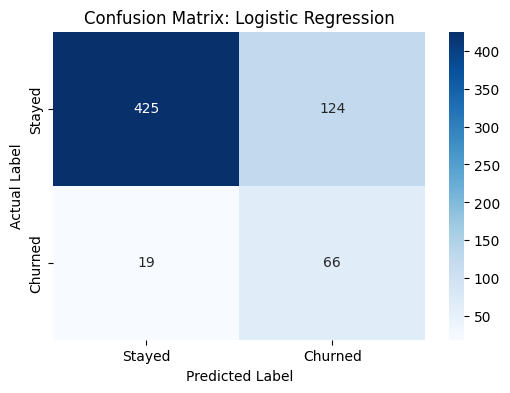

--- Logistic Regression ---
Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       549
           1       0.35      0.78      0.48        85

    accuracy                           0.77       634
   macro avg       0.65      0.78      0.67       634
weighted avg       0.88      0.77      0.81       634



0.7744479495268138

In [40]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
evaluate_model(lr, X_test, y_test, "Logistic Regression")

### DECISION TREE
Provides a flowchart of customer behavior splitting at specific thresholds of features considered important by the algorithm. 

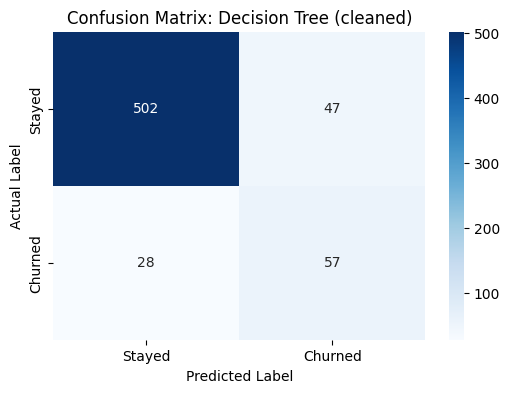

--- Decision Tree (cleaned) ---
Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       549
           1       0.55      0.67      0.60        85

    accuracy                           0.88       634
   macro avg       0.75      0.79      0.77       634
weighted avg       0.89      0.88      0.89       634



0.8817034700315457

In [41]:
# cleaned 
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train, y_train)
evaluate_model(dt, X_test, y_test, "Decision Tree (cleaned)")

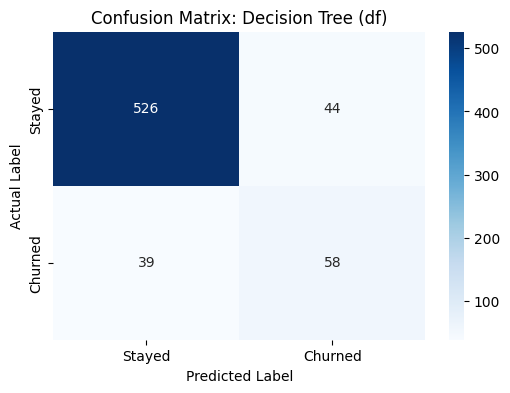

--- Decision Tree (df) ---
Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       570
           1       0.57      0.60      0.58        97

    accuracy                           0.88       667
   macro avg       0.75      0.76      0.75       667
weighted avg       0.88      0.88      0.88       667



0.8755622188905547

In [42]:
# original
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(Z_train, k_train)
evaluate_model(dt, Z_test, k_test, "Decision Tree (df)")

### RANDOM FOREST
Provides a stable Feature Importance ranking. We learn which features are the most "powerful" across many different scenarios.

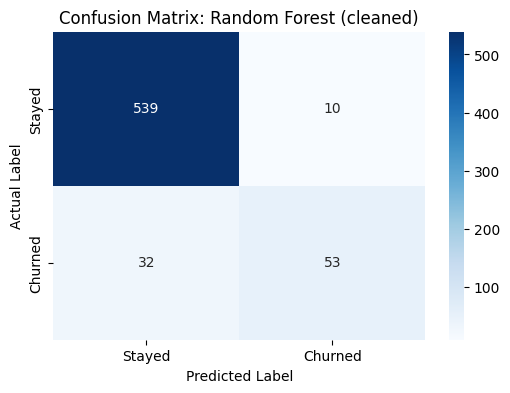

--- Random Forest (cleaned) ---
Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       549
           1       0.84      0.62      0.72        85

    accuracy                           0.93       634
   macro avg       0.89      0.80      0.84       634
weighted avg       0.93      0.93      0.93       634

--- Random Forest (Cleaned) ---
ROC-AUC Score: 0.8956
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       549
           1       0.84      0.62      0.72        85

    accuracy                           0.93       634
   macro avg       0.89      0.80      0.84       634
weighted avg       0.93      0.93      0.93       634



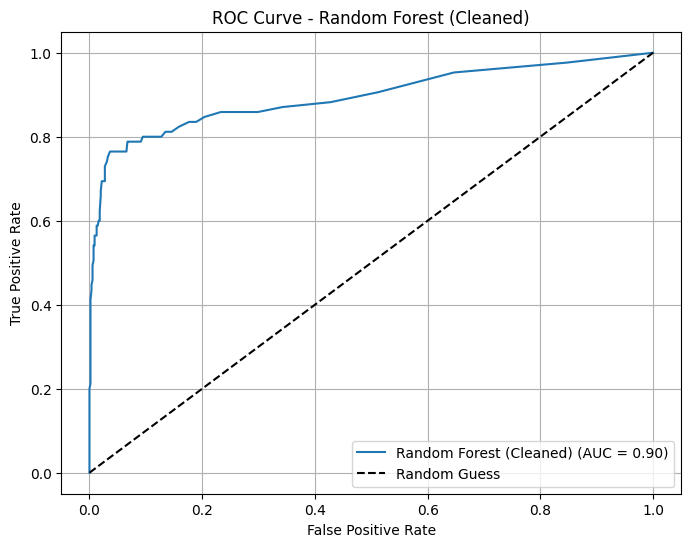

np.float64(0.8955534126218794)

In [43]:
# cleaned
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test, "Random Forest (cleaned)")
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

evaluate_model_with_roc(rf, X_test, y_test, "Random Forest (Cleaned)")

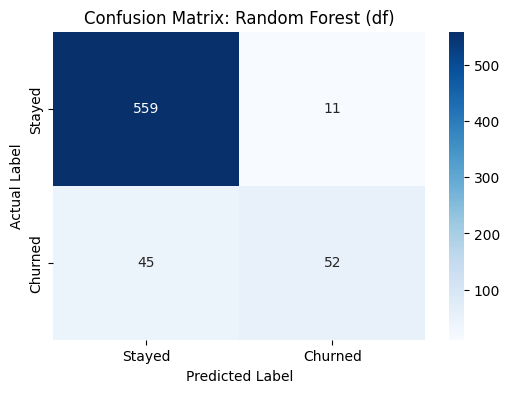

--- Random Forest (df) ---
Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       570
           1       0.83      0.54      0.65        97

    accuracy                           0.92       667
   macro avg       0.88      0.76      0.80       667
weighted avg       0.91      0.92      0.91       667



0.9160419790104948

In [44]:
# original
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(Z_train, k_train)
evaluate_model(rf, Z_test, k_test, "Random Forest (df)")

### GRADIENT BOOSTING (XGBoost)
XGBoost is a gradient boosting algorithm over decision trees that is well suited for handling imbalanced distribution through specific hyperparameters. It usually gives the highest predictive power because it combines many small decision trees to make a strong prediction, but it does so through Boosting (fixing the errors of previous trees). 

The model's tunable hyperparameters:
* **n_estimators** – number of trees / number of boosting iterations;
* **learning_rate** – gradient boosting step;
* **max_depth** – maximum depth of each tree;
* **subsample** – proportion of rows/features to build each tree;
* **colsample_bytree** - fraction of features for each tree;

* **gamma** – minimum improvement of loss function for node split;
* **lambda/alpha** – L2/L1 regularization.

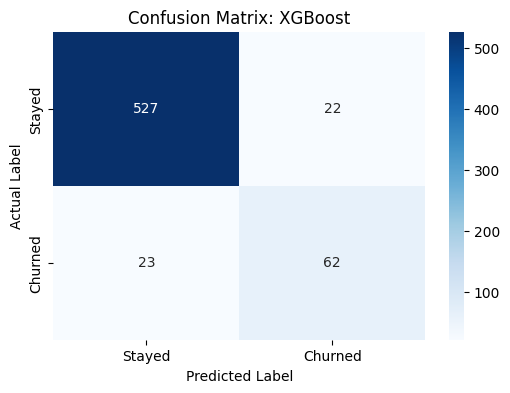

--- XGBoost ---
Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       549
           1       0.74      0.73      0.73        85

    accuracy                           0.93       634
   macro avg       0.85      0.84      0.85       634
weighted avg       0.93      0.93      0.93       634

--- XGBoost ---
ROC-AUC Score: 0.8783
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       549
           1       0.74      0.73      0.73        85

    accuracy                           0.93       634
   macro avg       0.85      0.84      0.85       634
weighted avg       0.93      0.93      0.93       634



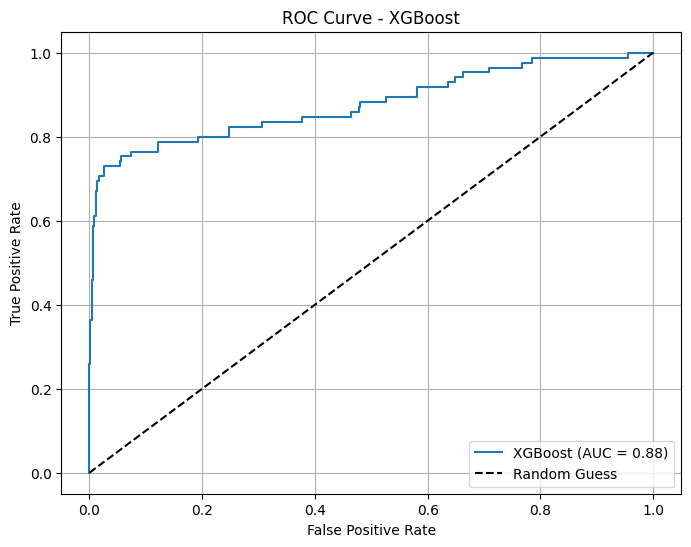

np.float64(0.8783027965284476)

In [45]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# Note: XGBoost usually requires manual handling of imbalance (scale_pos_weight)
weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb.set_params(scale_pos_weight=weight)
xgb.fit(X_train, y_train)
evaluate_model(xgb, X_test, y_test, "XGBoost")
evaluate_model_with_roc(xgb, X_test, y_test, "XGBoost")

### ANN

In [ ]:
# Define the architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='leaky_relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2), # Prevents overfitting on your small dataset
    tf.keras.layers.Dense(8, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, 
                    validation_split=0.2, verbose=0)

# Evaluate
ann_preds = (model.predict(X_test_scaled) > 0.5).astype("int32")
print("--- Artificial Neural Network ---")
print(classification_report(y_test, ann_preds))


C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
--- Artificial Neural Network ---
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       549
           1       0.78      0.54      0.64        85

    accuracy                           0.92       634
   macro avg       0.86      0.76      0.80       634
weighted avg       0.91      0.92      0.91       634



In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2), # Prevents overfitting on your small dataset
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, 
                    validation_split=0.2, verbose=0)

# Evaluate
ann_preds = (model.predict(X_test_scaled) > 0.5).astype("int32")
print("--- Artificial Neural Network ---")
print(classification_report(y_test, ann_preds))

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
--- Artificial Neural Network ---
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       549
           1       0.79      0.56      0.66        85

    accuracy                           0.92       634
   macro avg       0.86      0.77      0.81       634
weighted avg       0.92      0.92      0.92       634



### K-MEANS
Clusterize different types of customers that look similar to see the collective probability of churning. Use inertia (elbow rule) and silhouette score to find the best K. 

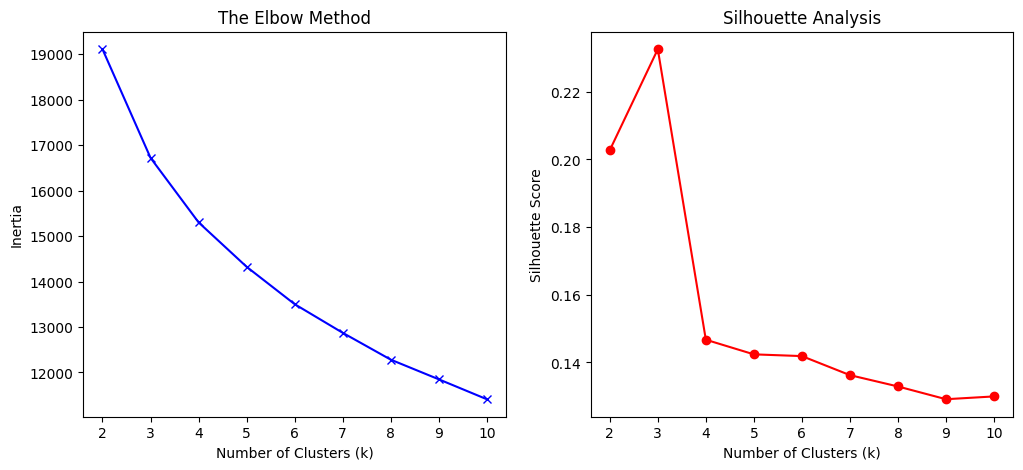

In [48]:
inertia = []
silhouette_avgs = []
k_range = range(2, 11) # Testing K from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    
    inertia.append(kmeans.inertia_)
    silhouette_avgs.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Plotting the Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method')

# Plotting the Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_avgs, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.show()

In [51]:
# Scale entire dataset, not just train
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned.drop('Churn', axis=1))

In [57]:
# Creating 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
# Add the results to your original DataFrame df (not the scaled one)
# to avoid conflict between numpy array X_scaled and pandas df
df_cleaned["Persona"]=clusters #use df_cleaned so that length of indexes match (df_cleaned and X_scale w/out outliers)
print(df_cleaned.groupby('Persona').mean())

            Churn  AccountWeeks  ...   RoamMins  PricePerMinute
Persona                          ...                           
0        0.394619    100.789238  ...  10.429148        0.287757
1        0.138838    100.530853  ...  10.048775        0.280922
2        0.043302    100.286874  ...  10.458593        0.449639

[3 rows x 10 columns]


In [58]:
# Creating 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df_cleaned['Persona'] = clusters
print(df_cleaned.groupby('Persona').mean())

            Churn  AccountWeeks  ...   RoamMins  PricePerMinute
Persona                          ...                           
0        0.394619    100.789238  ...  10.429148        0.287757
1        0.092523    103.961682  ...  10.513271        0.320739
2        0.046990    100.353891  ...  10.562849        0.450772
3        0.173658     97.401007  ...   9.592198        0.252741

[4 rows x 10 columns]


### SHAP (SHapley Additive exPlanations)
Add refined business expalantions to simple K-means statistics to understand the real reason for probability to churn in clusters. Shap does not explain raw data, but model predictions, this is the reason why we associate it to the already trained XGBoost which is the most promising. 

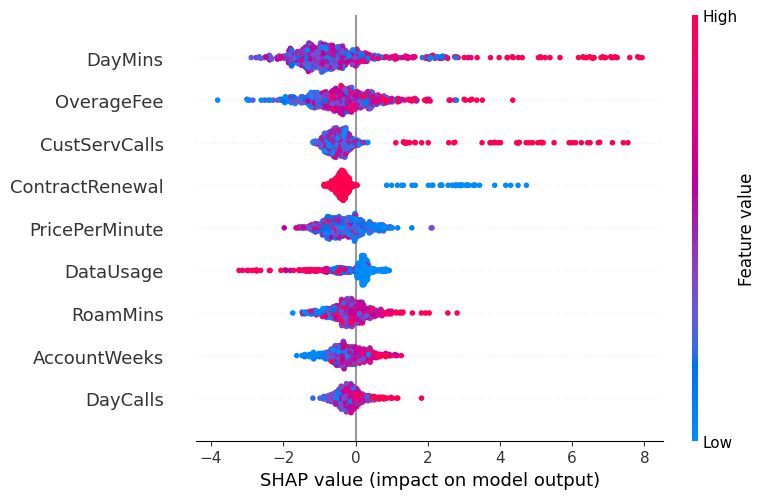

In [ ]:
# Initialize the SHAP Explainer
# TreeExplainer is specifically optimized for XGBoost because it uses trees
explainer = shap.TreeExplainer(xgb)

# Calculate SHAP values for the test set
# This tells us how much each feature contributed to each individual prediction
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)